# Reproducing Temporal Pointwise Convolutional Networks for ICU Length of Stay Prediction
## CS 598 DL4H
## Ryan McEvoy (rmcevoy2@illinois.edu) - Team 119
## [Video Walkthrough](https://youtu.be/Ly16212cThk)## [GitHub Repo](https://github.com/rmcevoy2/TPC_LoS_Replication)

# Introduction
The authors of the original paper, "Temporal Pointwise Convolutional Networks for Length of Stay Prediction in the Intensive Care Unit" [[1]](#references), aimed to address the financial, logistical, and medical issues presented by uncertainty related to patient length of stay (LoS) in the intensive care unit (ICU).

Accurate estimation of a patient’s LoS is assumed to have positive impact on patient experiences and decreases risks of hospital acquired infections and mortality, via better bed planning. The original paper’s authors assert that LoS prediction is currently handled manually by clinicians, which is often burdensome and inaccurate. The model proposed in the paper is designed to reduce the burden on clinicians, provide up-to-date predictions, and to aid in hospital bed planning.

The paper introduces a model called a Temporal Pointwise Convolution (TPC) model. This is a regression model that takes ICU patient electronic health records (EHR) data as input and outputs a predicted remaining length of stay. Features are paired with decay values that correspond how recent they are. The general structure of the model includes two different types of convolution layers; the temporal convolutional layers used to capture time dependencies, and the pointwise convolutional layers used to capture interactions between different features. The temporal convolutional layers do not share weights between features as it is intended to only extract feature-specific temporal trends. It includes skip connections so each layer has access to the original data. The pointwise convolution part of the TPC layers shares information across features, not time. The temporal convolutions and pointwise convolutions are concatenated and, after stacked TPC layers, the model has two final pointwise convolution layers and the final output.  

# Scope of Reproducibility:

## Hypothesis

This notebook will function as a test for the hypothesis that a temporal pointwise convolutional network can be trained to achieve better performance than LSTM or Transformer models for predicting ICU patient lengths of stay. The metric to evaluate this is the Mean Logarithmic Square Error.

# Methodology


In [1]:
import numpy as np
import pandas as pd
import os
import torch
import json
import trixi
import sklearn

import matplotlib.pyplot as plt
import sys


!python -V
np.__version__, pd.__version__, torch.__version__, trixi.__version__, sklearn.__version__

c:\Users\mcevo\Documents\UIUC\CS 598 Deep Learning for Healthcare\Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\mcevo\Documents\UIUC\CS 598 Deep Learning for Healthcare\Project\.venv\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


Python 3.7.8


('1.18.1', '0.24.2', '1.5.0+cpu', '0.1.2.2', '0.20.2')

##  Data
### Preprocessing
This project utilizes the eICU Collaborative Research Database [[2, 3]](#references). Significant preprocessing is done to work the data into a useful format.
  * Data is available from PhysioNet [[4]](#references) to credentialed users.
  * Once data is downloaded, it must be set up as a local PostgreSQL database.
  * Update the eICU_path string in paths.json to a directory to store the processed data.
  * Modify the same string within eICU_preprocessing/create_all_tables.sql
  * With psql, run eICU_preprocessing/create_all_tables.sql from the repository of the original paper

In [2]:
#psql 'dbname=eicu user=eicu options=--search_path=eicu'
#\i eICU_preprocessing/create_all_tables.sql
#\q

  * Run preprocessing script.

In [3]:
from eICU_preprocessing.run_all_preprocessing import main as preprocess
# preprocess()

  * Optionally, reduce the dataset to a more managable size for available compute resources.

In [4]:
# generate smaller datasets by only using total * scale_factor patients
def gen_subset(scale_factor:float, data_dir:str):
    for split in ["train","test","val"]:
        print("generating subset of " + split)
        split_dir = data_dir + "/" + split
        subset_dir = data_dir + "/subset/" + split
        if not os.path.exists(subset_dir):
            os.makedirs(subset_dir)

        subset_labels = pd.read_csv(split_dir + "/" + "labels.csv", index_col="patient").sample(frac=scale_factor)
        print(str(len(subset_labels)) + " patients in subset")
        subset_labels.to_csv(subset_dir + "/" + "labels.csv")
        subset_flat = pd.read_csv(split_dir + "/" + "flat.csv", index_col="patient").loc[subset_labels.index]
        subset_flat.to_csv(subset_dir + "/" + "flat.csv")
        subset_diagnoses = pd.read_csv(split_dir + "/" + "diagnoses.csv", index_col="patient").loc[subset_labels.index]
        subset_diagnoses.to_csv(subset_dir + "/" + "diagnoses.csv")
        subset_timeseries = pd.read_csv(split_dir + "/" + "timeseries.csv", index_col="patient").loc[subset_labels.index]
        subset_timeseries.to_csv(subset_dir + "/" + "timeseries.csv")

data_dir = "C:/Users/mcevo/Documents/UIUC/CS 598 Deep Learning for Healthcare/Project/Data/preprocessed/eicu/"
#gen_subset(0.1, data_dir)

use_subset = True

if use_subset:   
    with open("paths.json", "r") as data_paths: 
        data_json = json.load(data_paths)
    data_json["eICU_path"] = data_dir + "subset/"
    with open("paths.json", "w") as data_paths: 
        json.dump(data_json, data_paths)
else:
    with open("paths.json", "r") as data_paths: 
        data_json = json.load(data_paths)
    data_json["eICU_path"] = data_dir
    with open("paths.json", "w") as data_paths: 
        json.dump(data_json, data_paths)

Data has been split into train, test, and validation splits. Each split includes *labels.csv, flat.csv, diagnoses.csv,* and *timeseries.csv*. The *labels.csv* data includes administrative information regarding patients' ICU stays and include the target *actuallos* feature. The *flat.csv* data mostly includes patient demographic information and does not include any time-dependent features. *diagnoses.csv* data represent boolean encodings of diagnoses, with one record for each patient. *timeseries.csv* includes test data for patients with time stamps relative to their admission.

### Statistics


total number of patients: 9018
lengths of stay stats: 
count    9018.000000
mean        3.018798
std         3.800468
min         0.168000
25%         1.015900
50%         1.867650
75%         3.478225
max        82.788800
Name: actualiculos, dtype: float64


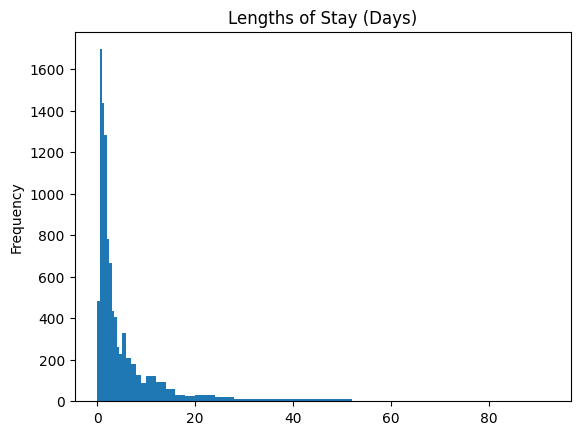

patient information: 
       gender          age  admissionheight  admissionweight         hour  \
count    9018  9018.000000      9018.000000      9018.000000  9018.000000   
unique      2          NaN              NaN              NaN          NaN   
top      True          NaN              NaN              NaN          NaN   
freq     4868          NaN              NaN              NaN          NaN   
mean      NaN     0.167516         0.009216        -0.149298     0.060922   
std       NaN     0.575097         0.805195         0.639755     0.682879   
min       NaN    -1.413793        -4.000000        -2.235955    -1.000000   
25%       NaN    -0.172414        -0.495918        -0.580524    -0.652174   
50%       NaN     0.241379         0.049276        -0.225968     0.217391   
75%       NaN     0.620690         0.617414         0.153558     0.739130   
max       NaN     1.034483         4.000000         4.000000     1.000000   

       teachingstatus ethnicity_African American ethn

In [5]:
# dir and function to load raw data

with open("paths.json", "r") as data_paths:
    data_dir = json.load(data_paths)["eICU_path"]

def load_all_data(data_dir):
  # implement this function to load raw data to dataframe/numpy array/tensor
    data_dict = {}
    for split in ["train","test","val"]:
        split_dir = data_dir + "/" + split
        data_dict[split] = {
            "labels" : pd.read_csv(split_dir + "/labels.csv", index_col="patient"),
            "flat" : pd.read_csv(split_dir + "/flat.csv", index_col="patient"),
            "diagnoses" : pd.read_csv(split_dir + "/diagnoses.csv", index_col="patient"),
            "timeseries" : pd.read_csv(split_dir + "/timeseries.csv", index_col=["patient", "time"])
        }
        for col in data_dict[split]["flat"].columns:
            if col in ("age","admissionheight","admissionweight","hour"):
                continue
            data_dict[split]["flat"][col] = data_dict[split]["flat"][col].astype('bool')
    return data_dict

data_dict = load_all_data(data_dir)

def combined_data(data_dict):
    return {"labels" : pd.concat([data_dict["train"]["labels"],data_dict["test"]["labels"],data_dict["val"]["labels"]], axis=0),
    "flat" : pd.concat([data_dict["train"]["flat"],data_dict["test"]["flat"],data_dict["val"]["flat"]], axis=0),
    "diagnoses" : pd.concat([data_dict["train"]["diagnoses"],data_dict["test"]["diagnoses"],data_dict["val"]["diagnoses"]], axis=0),
    "timeseries" : pd.concat([data_dict["train"]["timeseries"],data_dict["test"]["timeseries"],data_dict["val"]["timeseries"]], axis=0)}

# calculate statistics
def calculate_stats(data_dict):


    all_data = combined_data(data_dict)
    print("total number of patients: " + str(len(all_data["labels"].index)))
    print("lengths of stay stats: ")
    print(all_data["labels"]["actualiculos"].describe())
    los_bin_edges = np.concatenate((np.arange(0,5,0.5),np.arange(5,10),np.arange(10,20,2),np.arange(20,32,4),np.arange(32,100,20)))
    all_data["labels"]["actualiculos"].plot.hist(bins=los_bin_edges, title='Lengths of Stay (Days)')

    plt.show()

    print("patient information: ")
    print(all_data["flat"].describe(include='all'))

calculate_stats(data_dict)


##   Model
The primary model for this paper is the Temporal Pointwise Convolutional Network.


### Model architecture


The tuned TPC model uses 15 epochs, a batch size of 32, 9 TPC layers, a convolution kernal size of 4, a learning rate of 0.00226, and a dropout rate of 0.05 percent for temporal-only nodes and 0.45 for other nodes.

The model is trained to minimize the mean logarithmic square error (MSLE). MSLE is used because LoS prediction for longer stays is more difficult to predict with the same absolute accuracy as for shorter stays.

### Model training

Train a very much scaled down version of the model

In [6]:
!python -m models.run_tpc --model_type tpc --n_layers 1 --n_epochs 3 --percentage_data 1

Config:
{
    "L2_regularisation": 0,
    "alpha": 100,
    "base_dir": "models/experiments/eICU/LoS/TPC",
    "batch_size": 32,
    "batch_size_test": 32,
    "batchnorm": "mybatchnorm",
    "dataset": "eICU",
    "diagnosis_size": 64,
    "disable_cuda": false,
    "exp_name": "TPC",
    "intermediate_reporting": false,
    "kernel_size": 4,
    "labs_only": false,
    "last_linear_size": 17,
    "learning_rate": 0.00226,
    "loss": "msle",
    "main_dropout_rate": 0.45,
    "mode": "train",
    "model_type": "tpc",
    "n_epochs": 3,
    "n_layers": 1,
    "name": "TPC",
    "no_diag": false,
    "no_exp": false,
    "no_labs": false,
    "no_mask": false,
    "no_skip_connections": false,
    "no_temp_kernels": 12,
    "percentage_data": 1.0,
    "point_size": 13,
    "point_sizes": [
        13
    ],
    "save_results_csv": false,
    "seed": 3550966580,
    "share_weights": false,
    "shuffle_train": false,
    "sum_losses": true,
    "task": "LoS",
    "temp_dropout_rate": 0.

c:\Users\mcevo\Documents\UIUC\CS 598 Deep Learning for Healthcare\Project\.venv\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
c:\Users\mcevo\Documents\UIUC\CS 598 Deep Learning for Healthcare\Project\.venv\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\mcevo\Documents\UIUC\CS 598 Deep Learning for Healthcare\Project\.venv\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uin

In [7]:
!python -m models.run_tpc --model_type temp_only --n_layers 1 --n_epochs 3 --percentage_data 1

Config:

c:\Users\mcevo\Documents\UIUC\CS 598 Deep Learning for Healthcare\Project\.venv\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
c:\Users\mcevo\Documents\UIUC\CS 598 Deep Learning for Healthcare\Project\.venv\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\mcevo\Documents\UIUC\CS 598 Deep Learning for Healthcare\Project\.venv\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uin


{
    "L2_regularisation": 0,
    "alpha": 100,
    "base_dir": "models/experiments/eICU/LoS/TPC",
    "batch_size": 32,
    "batch_size_test": 32,
    "batchnorm": "mybatchnorm",
    "dataset": "eICU",
    "diagnosis_size": 64,
    "disable_cuda": false,
    "exp_name": "TPC",
    "intermediate_reporting": false,
    "kernel_size": 4,
    "labs_only": false,
    "last_linear_size": 17,
    "learning_rate": 0.00226,
    "loss": "msle",
    "main_dropout_rate": 0.45,
    "mode": "train",
    "model_type": "temp_only",
    "n_epochs": 3,
    "n_layers": 1,
    "name": "TPC",
    "no_diag": false,
    "no_exp": false,
    "no_labs": false,
    "no_mask": false,
    "no_skip_connections": false,
    "no_temp_kernels": 12,
    "percentage_data": 1.0,
    "point_size": 13,
    "point_sizes": [
        13
    ],
    "save_results_csv": false,
    "seed": 1897037139,
    "share_weights": false,
    "shuffle_train": false,
    "sum_losses": true,
    "task": "LoS",
    "temp_dropout_rate": 0.0

In [8]:
!python -m models.run_tpc --model_type pointwise_only --n_layers 1 --n_epochs 3 --percentage_data 1

Config:

c:\Users\mcevo\Documents\UIUC\CS 598 Deep Learning for Healthcare\Project\.venv\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
c:\Users\mcevo\Documents\UIUC\CS 598 Deep Learning for Healthcare\Project\.venv\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\mcevo\Documents\UIUC\CS 598 Deep Learning for Healthcare\Project\.venv\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uin


{
    "L2_regularisation": 0,
    "alpha": 100,
    "base_dir": "models/experiments/eICU/LoS/TPC",
    "batch_size": 32,
    "batch_size_test": 32,
    "batchnorm": "mybatchnorm",
    "dataset": "eICU",
    "diagnosis_size": 64,
    "disable_cuda": false,
    "exp_name": "TPC",
    "intermediate_reporting": false,
    "kernel_size": 4,
    "labs_only": false,
    "last_linear_size": 17,
    "learning_rate": 0.00226,
    "loss": "msle",
    "main_dropout_rate": 0.45,
    "mode": "train",
    "model_type": "pointwise_only",
    "n_epochs": 3,
    "n_layers": 1,
    "name": "TPC",
    "no_diag": false,
    "no_exp": false,
    "no_labs": false,
    "no_mask": false,
    "no_skip_connections": false,
    "no_temp_kernels": 12,
    "percentage_data": 1.0,
    "point_size": 13,
    "point_sizes": [
        13
    ],
    "save_results_csv": false,
    "seed": 3254728244,
    "share_weights": false,
    "shuffle_train": false,
    "sum_losses": true,
    "task": "LoS",
    "temp_dropout_rate"

# Results

## Training and Validation MSLE
TPC Model

![tpc train](models/experiments/eICU/LoS/TPC/2024-05-07_2241591/plot/train_msle.png)
![tpc val](models/experiments/eICU/LoS/TPC/2024-05-07_2241591/plot/val_msle.png)


Temporal-only Model

![temporal train](models/experiments/eICU/LoS/TPC/2024-05-07_2243231/plot/train_msle.png)
![temporal val](models/experiments/eICU/LoS/TPC/2024-05-07_2243231/plot/val_msle.png)


Pointwise-only Model

![pointwise train](models/experiments/eICU/LoS/TPC/2024-05-07_2244431/plot/train_msle.png)
![pointwise val](models/experiments/eICU/LoS/TPC/2024-05-07_2244431/plot/val_msle.png)


The complexity of the model architecture (using 1 TPC layer) and the extremely small data subset required to train these models with this notebook yield results that are not useful, but demonstrate the models are reducing training loss over each epoch.

## Model comparison

The original paper published results showing their TPC model achieved MSLE of 0.70, with the pointwise only model achieving MSLE of 1.60, and the temporal only model achieving MSLE of 0.86.

The arbitrarily small models trained within this notebook are obviously not comparable to the models of the original paper.


# Discussion

In the current state of this project, the results from the original paper have not been reporduced. This is mostly due to insufficient computational power/time and incompatibilities with the libraries originally used for the model.

The trixi library appears to be no longer maintained and is therefore very out of date. Efforts were made to refactor the code to no longer use this library, but this lead to many new issues.

Subsequently, older versions of python, pytorch, numpy, etc. were used to run the original code with fewer modifications. This was somewhat challenging, as pre-configured environments were not readily available. VMs using GPUs were provisioned through Google Cloud Platform. Specifically, the "G2" VM was used, with 32 GB RAM. Several attempts were made to train a TPC model using these VMs, but all attempts ended in errors. After many attempts, the cost of the compute resources were too great to justify continuing attempts to train a successful mode.

Given more resources, the models demonstrated in the original paper may have been reproducible, but were not given the aforementioned circumstances.

# References

1. Emma Rocheteau, Pietro Liò, and Stephanie Hyland. 2021. Temporal pointwise convolutional networks for length of stay prediction in the intensive care unit. In Proceedings of the Conference on Health, Inference, and Learning (CHIL '21). Association for Computing Machinery, New York, NY, USA, 58–68. https://doi.org/10.1145/3450439.3451860
2. Pollard, T., Johnson, A., Raffa, J., Celi, L. A., Badawi, O., & Mark, R. (2019). eICU Collaborative Research Database (version 2.0). PhysioNet. https://doi.org/10.13026/C2WM1R.
3. Pollard TJ, Johnson AEW, Raffa JD, Celi LA, Mark RG and Badawi O. Scientific Data (2018). DOI: http://dx.doi.org/10.1038/sdata.2018.178.
4. Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.


